# 最新のCOVID-19のデータをWikiから（厚労省のデータ一覧）取得

In [130]:
from urllib import request
from bs4 import BeautifulSoup
response = request.urlopen('https://en.wikipedia.org/wiki/COVID-19_pandemic_in_Japan')
soup = BeautifulSoup(response)
response.close()

# WikipediaデータからCOVID-19のデータを取得して予測

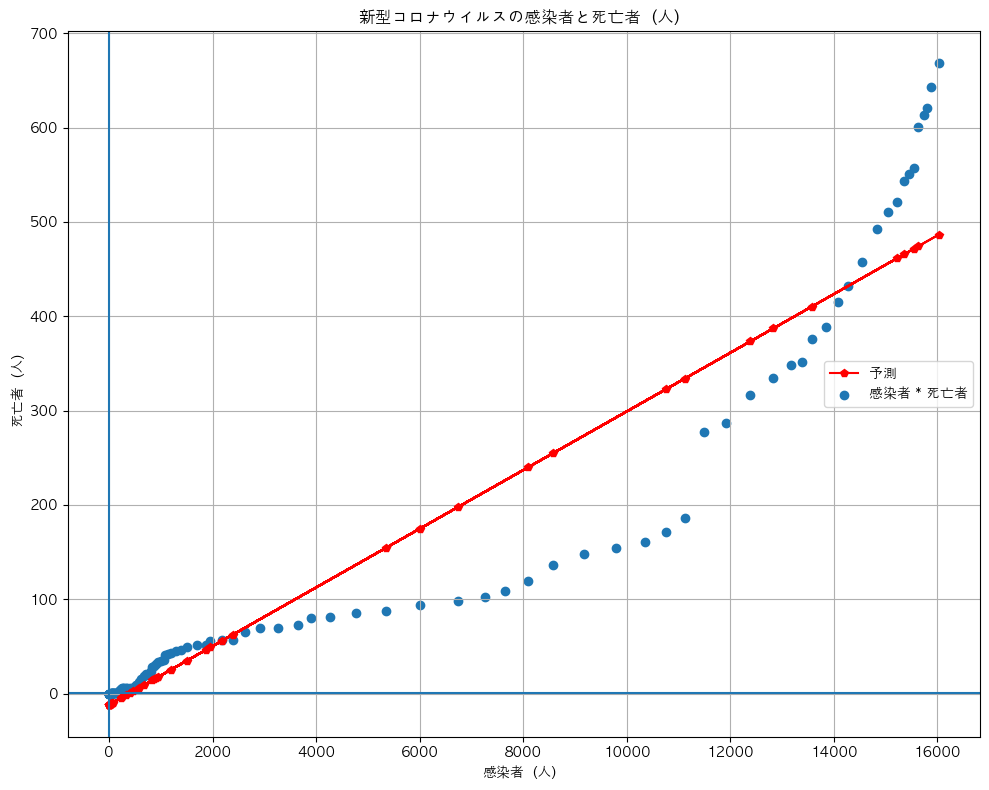

検証期間: 2020-01-16 〜 2020-05-12
学習用データ: 乖離値=59.789236, 説明変数の目的変数合致率=0.919565
検証用データ: 乖離値=51.778170, 説明変数の目的変数合致率=0.892385


In [136]:
import dataclasses
import numpy
from math import sqrt
from sklearn.metrics import mean_squared_error
@dataclasses.dataclass
class Covid19TTS:
    train: numpy.ndarray
    test: numpy.ndarray
@dataclasses.dataclass
class Score:
    train: numpy.float64
    test: numpy.float64
@dataclasses.dataclass
class Covid19MS:
    x: Covid19TTS
    y: Covid19TTS
    pred: Covid19TTS
@dataclasses.dataclass
class Covid19Score:
    rmse: Score
    r2: Score
    def output(self):
        self.__train_output()
        self.__test_output()
    def __train_output(self):
        print('学習用データ: 乖離値=%5f, 説明変数の目的変数合致率=%5f' % (self.rmse.test, self.r2.train))
    def __test_output(self):
        print('検証用データ: 乖離値=%5f, 説明変数の目的変数合致率=%5f' % (self.rmse.train, self.r2.test))

import re
import pandas as pd
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['font.family'] = 'AppleGothic'
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
class Covid19:
    def __init__(self):
        self.lr = LinearRegression()
        self.df = self.__wiki2df()
        self.__set_x_and_y()
        self.__set_tts()
    def execute(self):
        self.__plot_scatter()
        return self
    def __plot_scatter(self, test_size=0.4):
        self.lr.fit(self.X_train, self.y_train)
        y_test_pred = self.lr.predict(self.X_test)
        self.__plot(y_test_pred)
        self.tts = Covid19MS(
            Covid19TTS(self.X_train, self.X_test),
            Covid19TTS(self.y_train, self.y_test),
            Covid19TTS(self.lr.predict(self.X_train), y_test_pred)
        )
    def __wiki2df(self):
        EXTRACT_DIGITS = lambda string: re.search(r'[\d,]+', string)
        data = []
        for rows in soup.find('div', class_='barbox tright').select('table')[0].select('tbody')[0].select('tr'):
            row = rows.select('td.bb-04em')
            if len(row) == 0:
                continue
            date = row[0].text
            case = EXTRACT_DIGITS(row[1].text)
            if case != None:
                case = case.group()
            death = EXTRACT_DIGITS(row[2].text)
            if death != None:
                death = death.group()
            data.append({'date': date, 'case': case, 'death': death})
        return pd.DataFrame(data)
    def __set_x_and_y(self):
        AUTO_RESHAPE_DIGITS = lambda column: pd.DataFrame(
            [0 if x == None else int(x.replace(',', '')) for x in column.values]
        ).values.reshape(-1, 1)
        self.case = AUTO_RESHAPE_DIGITS(self.df.case)
        self.death = AUTO_RESHAPE_DIGITS(self.df.death)
    def __set_tts(self, test_size=0.4):
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.case,
            self.death,
            test_size=test_size,
            random_state=0
        )
    def __plot(self, y_test_pred):
        plt.figure(figsize=(10,8), dpi=100, tight_layout=True)
        plt.title('新型コロナウイルスの感染者と死亡者（人）')
        plt.scatter(self.case, self.death, label='感染者 * 死亡者')
        plt.plot(self.X_test, y_test_pred, color='red', marker='p', label='予測')
        plt.xlabel('感染者（人）')
        plt.ylabel('死亡者（人）')
        plt.grid(True)
        plt.axhline(0.5)
        plt.axvline(0.5)
        plt.legend(loc='best')
        plt.show()
class Executer:
    def __init__(self, covid19):
        print('検証期間: %s 〜 %s' % (covid19.df.iloc[0].date, covid19.df.iloc[-1].date))
        lr = covid19.lr
        tts = covid19.tts
        Covid19Score(
            Score(
                sqrt(mean_squared_error(tts.y.train, tts.pred.train)),
                sqrt(mean_squared_error(tts.y.test, tts.pred.test))
            ),
            Score(lr.score(tts.x.train, tts.y.train), lr.score(tts.x.test, tts.y.test))
        ).output()

Executer(Covid19().execute())

# 東京都のデータを分析

In [230]:
tokyo_patients = pd.read_csv('https://stopcovid19.metro.tokyo.lg.jp/data/130001_tokyo_covid19_patients.csv')

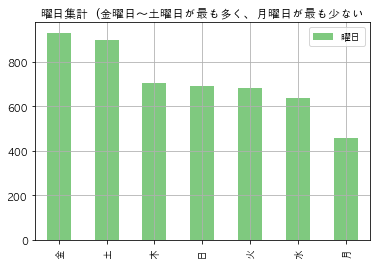

In [133]:
days_counts = tokyo_patients.loc[:,'曜日'].value_counts()
days_counts.plot(title='曜日集計（金曜日〜土曜日が最も多く、月曜日が最も少ない', grid=True, colormap='Accent', legend=True, alpha=1, kind='bar')

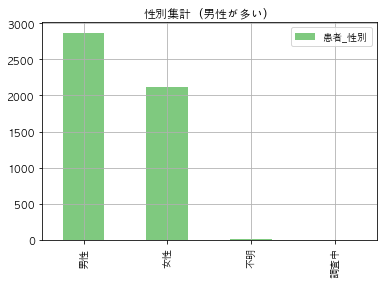

In [276]:
tokyo_patients.loc[:,'患者_性別'].value_counts().plot(title='性別集計（男性が多い）', grid=True, colormap='Accent', legend=True, alpha=1, kind='bar') 

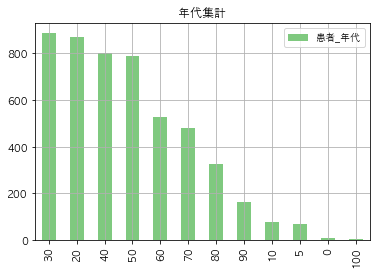

In [277]:
tokyo_patients.loc[:,'患者_年代'].replace('(\d+)代', r'\1', regex=True).replace('10歳未満', 5).replace('不明|-', 0, regex=True).replace('100歳以上', 100).astype(numpy.int64).value_counts().plot(title='年代集計', grid=True, colormap='Accent', legend=True, alpha=1, kind='bar') 